# Zadania - regresja logistyczna

### Normalizacja danych

Do danych z ostatnich zajęć (`gratkapl.csv`), podzielonych na zbiór treningowy (pierwsze 4000 elementów) i testowy (ostatnie 1000 elementów) wykonaj następujące polecenia:

1. W zbiorze treningowym usuń elementy odstające, pozostawiając jedynie te przykłady, w których dla każdej cechy $x_i$ zachodzi: $$ \mu_i-n\sigma_i < x_i < \mu_i + n\sigma_i,$$ gdzie $\mu$ to średnia, $\sigma$ to odchylenie standardowe, a $n$ to stała, np. 1 lub 2.
1. Stwórz model regresyjny z wykorzystaniem metody gradientu prostego: jak zachowuje się regresja według ceny bez normalizacji danych? Dla wybranch ustawień stwórz wykres pokazujący wartości funkcji kosztu dla pierwszych $n$ kroków.
1. Dokonaj normalizacji cech wykorzystując standardyzację.
1. Stwórz ponownie model regresyjny na znormalizowanych danych, sprawdź podobne ustawienia i wygeneruj nowe wykresy: jak teraz zachowuje się funkcja kosztu na $n$ kroków?

### Regresja logistyczna

Plik `gratkapl-centrenrm.csv` zawiera dane wzbogacone o nową cechę _Centre_ przyjmującą wartość 1, jeżeli lokalizacja mieszkania to centrum i 0 wpp. Kolumna ta została dodana w sposób automatyczny, na podstawie występowania słowa "centrum" w lokalizacji, jednocześnie słowo to zostało usunięte z opisu lokalizacji. 

Zamiast przywidywania ceny mieszkania, spróbuj przewidzieć lokalizację mieszkania: _centrum_ vs. _nie-centrum_ za pomocą regresji logistcznej.

1. Podziel dane trenujące na nowe dane treningowe (pierwsze 4/5 danych) i testowe (ostatnie 1/5 danych)
1. Stwórz dwuklasowy model regresji logistycznej, korzystając z cech liczbowych _Expected,Rooms,SqrMeters,Floor_. Warto usunąć szum i dokonać normalizacji danych.
1. Podaj procent poprawnych wyników (tzw. skuteczność, _accuracy_) dla zestawu testowego. Otrzymaną wartość porównaj z wynikiem uzyskiwanym przez klasyfikator losowy.
1. Do cech liczbowych, dodaj cechy obliczone na podstawie kolumn _Location_ i _Description_ i ponownie oblicz skuteczność.

In [91]:
# importy

import numpy as np
import pylab as pl
import pandas as pd
import re
from collections import defaultdict
import random
import seaborn as sns
%matplotlib inline

## Zadanie 1

In [92]:
# wczytywanie danych

def read_from_file(filename, cols):
    return pd.read_csv(filename, encoding='utf8', header=0, usecols=cols)

def create_train_test_sets(df):
    n, _ = df.shape
    n = int(0.8 * n)
    train, test = df[:n], df[n:]
    
    return train, test

def reject_outliers(df, key, m):
    return df[np.abs(df[key] - df[key].mean()) < m * df[key].std()]

def get_data_wthout_outliers(df, key, m=1):
    return reject_outliers(df, key, m)

def get_XY(df, labels, y_label):
    Xn = df[labels].as_matrix()
    yn = df[y_label].as_matrix()
    m, n = Xn.shape

    X = np.matrix(np.concatenate((np.ones((m, 1)), Xn), axis=1)).reshape(m, n+1)
    y = np.matrix(yn).reshape(m, 1)
    
    return X, y

In [93]:
# draw plot

def hMx(theta, X):
    return X*theta

def JMx(theta, X, y):
    m = len(y)
    J = 1.0/(2.0*m)*((X*theta-y).T*(X*theta-y))
    return J.item()

def contourPlot(X, y, rescale=10**10):
    y = y / 1000.0
    theta0_vals = np.linspace(-100000, 100000, 100)
    theta1_vals = np.linspace(-100000, 100000, 100)

    J_vals = np.zeros(shape=(theta0_vals.size, theta1_vals.size))
    for t1, element in enumerate(theta0_vals):
        for t2, element2 in enumerate(theta1_vals):
            thetaT = np.matrix([1.0, element, element2]).reshape(3,1)
            J_vals[t1, t2] = JMx(thetaT, X, y) / rescale
            
    pl.figure()
    pl.contour(theta0_vals, theta1_vals, J_vals.T, np.logspace(-2, 3, 20))
    pl.xlabel('$\Theta_1$')
    pl.ylabel('$\Theta_2$')

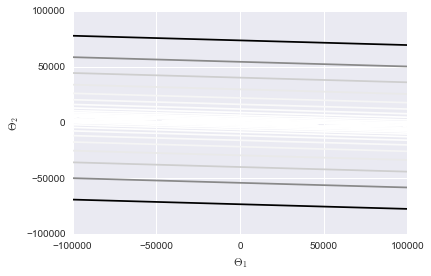

In [94]:
df = read_from_file('gratkapl.csv', ['Expected', 'Rooms', 'SqrMeters'])
train, test = create_train_test_sets(df)
train = get_data_wthout_outliers(train, 'Expected', 2)
XMx, yMx = get_XY(train, ['Rooms', 'SqrMeters'], 'Expected')
contourPlot(XMx, yMx)

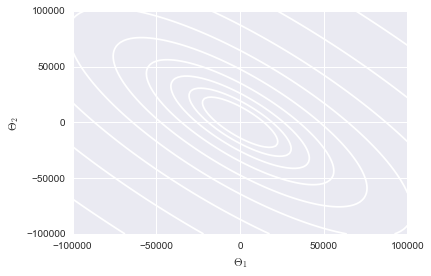

In [95]:
XMx_std = (XMx - np.mean(XMx, axis=0)) / np.std(XMx, axis=0)
XMx_std[:,0] = 1 # nan otherwise, because std of [1, 1, ..., 1] is 0
contourPlot(XMx_std, yMx)

## Zadanie 2

In [96]:
def h(theta, X):
    return 1.0/(1.0 + np.exp(-X*theta))

def J(h, theta, X, y):
    m = len(y)
    h_val = h(theta,X)
    s1 = np.multiply(y, np.log(h_val))
    s2 = np.multiply((1 - y), np.log(1 - h_val))
    return -np.sum(s1 + s2, axis=0) / m

def dJ(h,theta,X,y):
    return 1.0/len(y)*(X.T*(h(theta,X)-y))

def GD(h, fJ, fdJ, theta, X, y, alpha=0.01, eps=10**-3, maxSteps=10000):
    errorCurr = fJ(h, theta, X, y)
    errors = [[errorCurr, theta]]
    while True:
        # oblicz nowe theta
        theta = theta - alpha * fdJ(h, theta, X, y)
        # raportuj poziom błędu
        errorCurr, errorPrev = fJ(h, theta, X, y), errorCurr
        # kryteria stopu
        if abs(errorPrev - errorCurr) <= eps:
            break
        if len(errors) > maxSteps:
            break
        errors.append([errorCurr, theta]) 
    return theta, errors

def classifyBi(theta, X):
    prob = h(theta, X).item()
    return (1, prob) if prob > 0.5 else (0, prob)

def calculateAcc(theta, X, y):
    acc = 0.0
    for i, rest in enumerate(y):
        cls, prob = classifyBi(theta, X[i])
        acc += cls == y[i].item()
    return acc

def calculateAccRand(y):
    acc = 0.0
    y_rand = [random.choice([0, 1]) for _ in range(len(y))]
    for i, rest in enumerate(y):
        acc += y_rand[i] == y[i].item()
    return acc

In [97]:
df = read_from_file('gratkapl-centrenrm.csv', ['Expected', 'Rooms', 'SqrMeters', 'Floor', 
                                               'Location', 'Centre', 'Description'])
train, test = create_train_test_sets(df)
X_train, y_train = get_XY(train, ['Expected', 'Rooms', 'SqrMeters', 'Floor'], 'Centre')
X_test, y_test = get_XY(test, ['Expected', 'Rooms', 'SqrMeters', 'Floor'], 'Centre')


X_train_std = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_train_std[:,0] = 1
X_test_std = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)
X_test_std[:,0] = 1

thetaTemp = np.ones(5).reshape(5,1)
thetaBest, errors = GD(h, J, dJ, thetaTemp, X_train_std, y_train, 
                       alpha=0.1, eps=10**-7, maxSteps=1000)

acc = calculateAcc(thetaBest, X_test_std, y_test)
rand = calculateAccRand(y_test)

print('Accuracy:', acc / len(X_test_std))
print('Random accuracy:', rand / len(X_test_std))
print('Difference:', acc / len(X_test_std) - rand / len(X_test_std)) 

Accuracy: 0.7574257425742574
Random accuracy: 0.5099009900990099
Difference: 0.24752475247524752


Accuracy jest na poziomie 75%. To o 25% więcej niż klasyfikator losowy, którego accuracy wynosi ok. 50%.

In [8]:
def get_districts(df):
    districts = []
    for line in df['Location']:
        match = re.search(r'Pozna(ń|n) (.*)', line)
        if match:
            sentence = match.group(2)
            if 'ul.' in sentence:
                list = match.group(2).split()
                sentence = ' '.join(list[:list.index('ul.')])
                
            list = sentence.split()
            if len(list) > 1:
                if re.search(r'Nowe|Stare|Górna|Dolna|Stary|Suchy', list[0]):
                    sentence = '%s %s' % (list[0], list[1])
                else:
                    sentence = list[0]
                    
            list = sentence.split('-')
            if len(list) > 1:
                if list[0] == 'Poznań':
                    sentence = list[1]
                    
            list = sentence.split('/')
            if len(list) > 1:
                sentence = list[0]
            
            if sentence:
                districts.append(sentence)
            elif sentence == 'Os.' or sentence == 'Św.':
                districts.append('unk')
            else:
                districts.append('unk')
        else:
            districts.append('unk')
    return districts

def encode_districts(lst):
    encoded_list = []
    districts = {
        'górczyn' : 1,
        'gorczyn' : 1,
        'junikowo' : 2,
        'dębiec' : 3,
        'debiec' : 3,
        'naramowice' : 4,
        'warszawskie' : 5,
        'ogrody' : 6,
        'rataje' : 7,
        'winogrady' : 8,
        'grunwald' : 9,
        'łazarz' : 10,
        'lazarz' : 10,
        'piątkowo' : 11,
        'piatkowo' : 11, 
        'chartowo' : 12,
        'wilda' : 13,
        'górna wilda' : 13,
        'gorna wilda' : 13,
        'dolna wilda' : 13,
        'jeżyce' : 14,
        'jezyce' : 14,
        'jerzyce' : 14, # niestety :(
        'stare miasto' : 15
    }
    for item in lst:
        try:
            encoded_list.append(districts[item.lower()])
        except KeyError:
            encoded_list.append(0)
    
    return encoded_list

def get_100_words(lst):
    word_dict = defaultdict(int)
    for line in lst:
        for word in line.split():
            word = word.strip(',.:;\'"()-?!*/• ').lower()
            word_dict[word] += 1
    
    return [key for key, value in sorted(word_dict.items(), key=lambda item: item[1], reverse=True)][:100]

def get_word_ratio(desc_list, top_words):
    size = len(top_words)
    word_ratio = []
    for desc in desc_list:
        ratio = 0
        for word in desc.split():
            word = word.strip(',.:;\'"()-?!*/• ').lower()
            if word in top_words:
                ratio += 1
        word_ratio.append(ratio/size)
        
    return word_ratio 
    
def add_district(df):
    df['District'] = encode_districts(get_districts(df))
    
def add_word_ratio(df):
    top_words = get_100_words(df['Description'])
    df['WordRatio'] = get_word_ratio(df['Description'], top_words)

In [81]:
df = read_from_file('gratkapl-centrenrm.csv', ['Expected', 'Rooms', 'SqrMeters', 'Floor', 
                                               'Location', 'Centre', 'Description'])
add_district(df)
add_word_ratio(df)

train, test = create_train_test_sets(df)

X_train, y_train = get_XY(train, ['Expected', 'Rooms', 'SqrMeters', 'Floor', 'WordRatio', 'District'], 
                          'Centre')
X_test, y_test = get_XY(test, ['Expected', 'Rooms', 'SqrMeters', 'Floor', 'WordRatio', 'District'], 
                        'Centre')

X_train_std = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_train_std[:,0] = 1
X_test_std = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)
X_test_std[:,0] = 1

thetaTemp = np.ones(7).reshape(7,1)
thetaBest, errors = GD(h, J, dJ, thetaTemp, X_train_std, y_train, 
                       alpha=0.1, eps=10**-7, maxSteps=1000)

acc_new = calculateAcc(thetaBest, X_test_std, y_test)

print("Accuracy:", acc_new / len(X_test_std))

Accuracy: 0.7673267326732673


Udało się poprawić wynik o prawie 1%!